라이브러리 불러오기

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt


생성자 (generator)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
11501568/11490434 [==============================] - 0s 0us/step
epoch:0  d_loss:0.7175  g_loss:0.7866
epoch:1  d_loss:0.4393  g_loss:0.4849
epoch:2  d_loss:0.3441  g_loss:0.1180
epoch:3  d_loss:0.4459  g_loss:0.0162
epoch:4  d_loss:0.6662  g_loss:0.0067
epoch:5  d_loss:0.7366  g_loss:0.0202
epoch:6  d_loss:0.

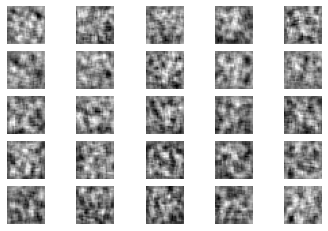

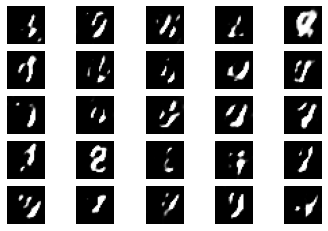

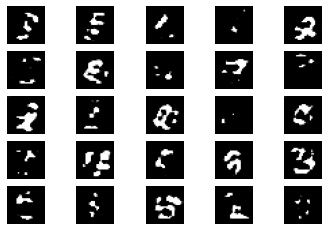

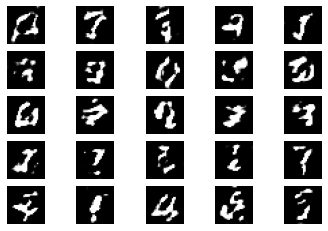

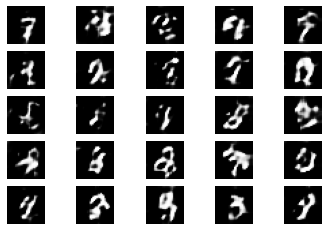

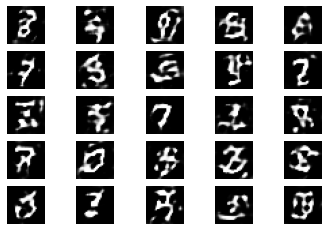

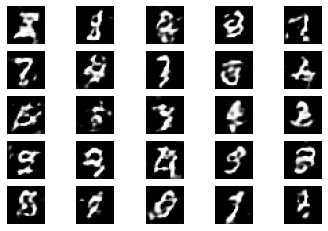

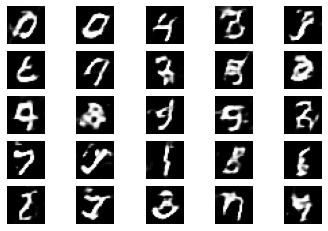

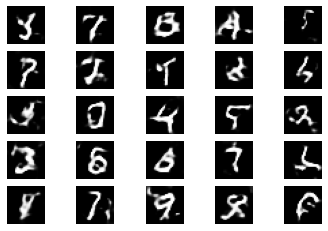

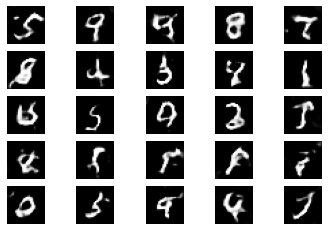

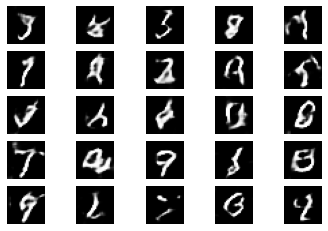

In [2]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False


ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

def gan_train(epoch, batch_size, saving_interval):
  (X_train, _), (_, _) = mnist.load_data()  
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

          if i % saving_interval == 0:

              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  


오토인코더

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

In [4]:
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

In [5]:
autoencoder = Sequential() 

autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28, 28, 1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, activation='relu', padding='same'))

autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 8)           584       
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 8)          

Epoch 1/50
469/469 [==============================] - 8s 16ms/step - loss: 0.0836 - val_loss: 0.0814
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.0823 - val_loss: 0.0814
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0823 - val_loss: 0.0816
Epoch 4/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0823 - val_loss: 0.0813
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0822 - val_loss: 0.0818
Epoch 6/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0821 - val_loss: 0.0810
Epoch 7/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0820 - val_loss: 0.0810
Epoch 8/50
469/469 [==============================] - 5s 12ms/step - loss: 0.0820 - val_loss: 0.0811
Epoch 9/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0819 - val_loss: 0.0816
Epoch 10/50
469/469 [==============================] - 6s 12ms/step - loss: 0.0818 - val_lo

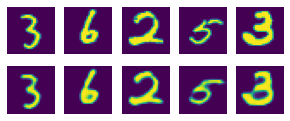

In [7]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

random_test = np.random.randint(X_test.shape[0], size=5) 
ae_imgs = autoencoder.predict(X_test)                    

plt.figure(figsize=(7, 2))                         

for i, image_idx in enumerate(random_test):       
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx].reshape(28, 28))   
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28)) 
   ax.axis('off')
plt.show()